<a href="https://colab.research.google.com/github/muppiit/PengolahanCitra_dan_VisiKomputer/blob/main/pokemon_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2  # Library untuk pengolahan citra

In [ ]:
# Step 2: Fungsi Pengolahan Citra dengan Ekstraksi RGB
def preprocess_image_rgb(image_path, target_size=(128, 128)):
    """
    Melakukan preprocessing citra: resize dan normalisasi dengan mempertahankan RGB.
    """
    # Load image
    image = cv2.imread(image_path)

    # Resize image
    image = cv2.resize(image, target_size)

    # Normalize RGB values to [0, 1]
    image = image / 255.0
    return image

In [ ]:
# Step 3: Dataset Preparation with Custom Preprocessing
def load_dataset_rgb(base_dir, target_size=(128, 128)):
    """
    Memuat dataset dengan preprocessing berbasis RGB.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    processed_image = preprocess_image_rgb(img_path, target_size)
                    images.append(processed_image)
                    labels.append(class_indices[class_name])
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_indices

base_dir = '/content/drive/MyDrive/PCVK/pokemon'
X, y, class_indices = load_dataset_rgb(base_dir)
print(f"Dataset loaded: {X.shape[0]} images, {len(class_indices)} classes")

Dataset loaded: 206 images, 4 classes


In [ ]:
# Step 4: Split Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(class_indices))
y_val = to_categorical(y_val, num_classes=len(class_indices))

In [ ]:
# Step 5: Model Building
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_indices), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 6: Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 7: Model Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 790ms/step - accuracy: 0.2072 - loss: 1.9580 - val_accuracy: 0.3095 - val_loss: 1.3447
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3939 - loss: 1.3182 - val_accuracy: 0.4048 - val_loss: 1.1661
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4686 - loss: 1.0980 - val_accuracy: 0.6667 - val_loss: 0.7739
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7081 - loss: 0.6397 - val_accuracy: 0.9524 - val_loss: 0.3469
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8423 - loss: 0.4172 - val_accuracy: 0.9524 - val_loss: 0.2247
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8425 - loss: 0.3634 - val_accuracy: 1.0000 - val_loss: 0.1103
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9220 - loss: 0.2096 - val_accuracy: 0.9762 - val_loss: 0.1147
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9573 - loss: 0.1719 - val_accuracy: 0.9762 - val_loss: 0.091

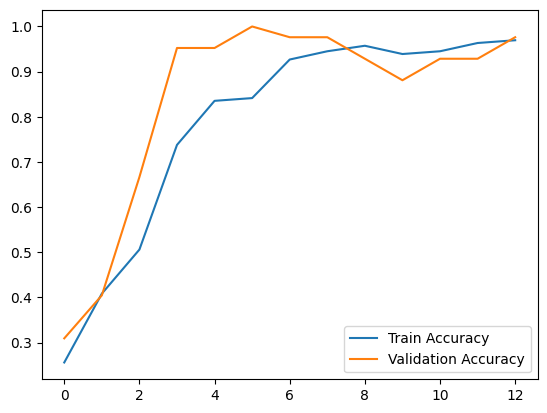

In [ ]:
# Step 8: Plot Performance
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Step 9: Save Model
model.save('pokemon_classifier_rgb.h5')

In [ ]:
# Step 10: Testing Model
def predict_image_rgb(image_path):
    processed_image = preprocess_image_rgb(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    class_names = list(class_indices.keys())
    return class_names[np.argmax(prediction)]

Saving c2.jpg to c2 (3).jpg
Processing uploaded file: c2 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: Charmander


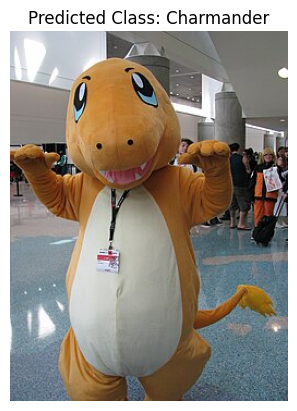

In [ ]:
from google.colab import files

def display_image_with_prediction(image_path, prediction):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Class: {prediction}")
    plt.show()

uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Processing uploaded file: {filename}")
    predicted_class = predict_image_rgb(filename)
    print("Predicted class:", predicted_class)
    display_image_with_prediction(filename, predicted_class)
